## Week 10 Spatial Analysis

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata


import seaborn as sns

from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Import the file

In [2]:
coral0 = gpd.read_file('CoralBleaching.csv')

In [3]:
coral0 = coral0.drop(columns=['geometry'])

### Convert the file into a proper GeoDataFrame

In [4]:
coral = pd.DataFrame(coral0)

In [5]:
type(coral)

pandas.core.frame.DataFrame

In [6]:
coral.LON = coral.LON.astype('float')
coral.LAT = coral.LAT.astype('float')

### Fix the wrong value in the dataset

In [7]:
coral.loc[coral['LAT'].idxmin()]

ID                                                                 29433
REGION                                                           Pacific
SUBREGION                                              Southwest Pacific
COUNTRY                                                  Solomon Islands
LOCATION                                                     Tuo village
LAT                                                               -10269
LON                                                              166.279
MONTH                                                                  8
YEAR                                                                2011
DEPTH                                                              2.5 m
SEVERITY_CODE                                                          0
BLEACHING_SEVERITY                                          No Bleaching
CORAL_FAMILY                                                            
CORAL_SPECIES                                      

In [8]:
print(coral[coral['LAT']==-10269].index.values)

[6087]


In [9]:
coral.loc[6087, 'LAT'] = -10.269

In [10]:
coral['LAT'][6087]

-10.269

### Plot a rough sketch of the dataset

In [11]:
coral = gpd.GeoDataFrame(coral, 
                     crs='EPSG:4326',
                     geometry=gpd.points_from_xy(coral.LON, coral.LAT))

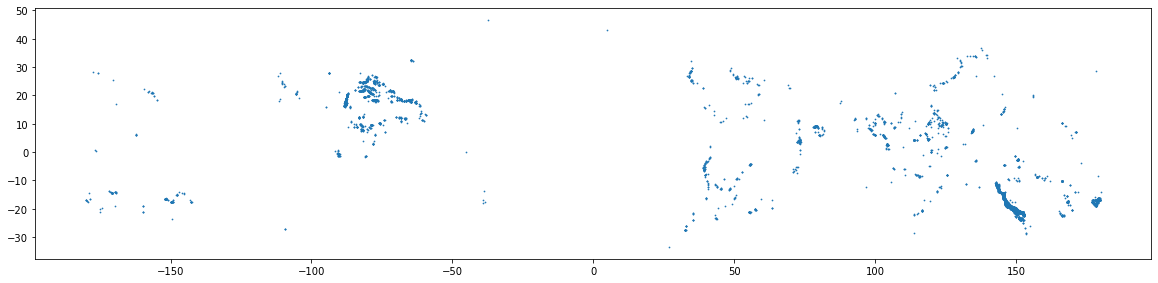

In [12]:
coral.plot(figsize=(20,20),
             markersize=0.5)

This map above is not able to tell us a lot, it just shows the distribution of all the points collected in the coral dataset.

### Develop the plot based on what we want to investigate

In [13]:
# import that interact library
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [14]:
coral.RECOVERY_CODE.value_counts()

     6099
3      47
2      17
0      15
1      12
Name: RECOVERY_CODE, dtype: int64

### Create an interractive map that shows the distribution of corals in different stages of recovery

In [16]:
# to make this function interactive
@interact

# function argument will become interactive; feeds in a list
def recovery_code(recovery=['0','1','2','3']):
    # table
    display(coral[coral.RECOVERY_CODE == recovery].head()) 

    # map
    ax = coral[coral.RECOVERY_CODE == recovery].plot(figsize=(20,60), markersize=10)
    
    # axis
    ax.axis('off')

    # basemap
    ctx.add_basemap(ax,
                    crs='epsg:4326', # surprise! You can change the crs here!
                    source=ctx.providers.CartoDB.Positron)

interactive(children=(Dropdown(description='recovery', options=('0', '1', '2', '3'), value='0'), Output()), _d…

I'm not sure why the map cannot be extended in height even though I have alrerady set the height to be 60. 
Comparerd to the more than 6,000 total data collected, the number of data that has a valid recovery code is very small. Regardless, from the map, we can still see that better recovery seems to have been recorded in the Caribbean region in that more dots with 0 or 1 recovery code (the lower the score the higher the recovery) are observed in this region. 

### Create a function to explore the centrography of coral mortality

In [47]:
def get_centrography(code='0'):
    mortality = coral.loc[(coral['MORTALITY_CODE']== code)]
    mortality['x'] = mortality.geometry.x
    mortality['y'] = mortality.geometry.y
    mean_center = centrography.mean_center(mortality[['x','y']])
    med_center = centrography.euclidean_median(mortality[['x','y']])
    # Generate scatter plot
    g = sns.jointplot(
        x='x', y='y', data=mortality, s=0.75, height=9
    )

    g.ax_joint.scatter(
        *mean_center, color='red', marker='x', s=50, label='Mean Center'
    )
    g.ax_marg_x.axvline(mean_center[0], color='red')
    g.ax_marg_y.axhline(mean_center[1], color='red')

    g.ax_joint.scatter(
        *med_center, color='limegreen', marker='o', s=50, label='Median Center'
    )
    g.ax_marg_x.axvline(med_center[0], color='limegreen')
    g.ax_marg_y.axhline(med_center[1], color='limegreen')

    g.ax_joint.legend()

    ctx.add_basemap(
        g.ax_joint, 
        crs='epsg:4326',
        source=ctx.providers.CartoDB.Positron
    )

    g.ax_joint.set_axis_off()

    # Display
    plt.show()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


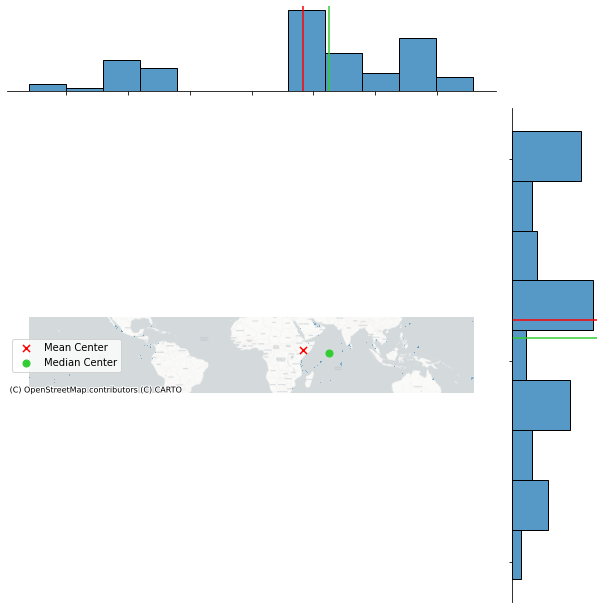

In [49]:
get_centrography(code='3')

I find that centrography might not be very useful to look at my dataset since the mean center and median center do not really reflect how these points are clustered. From the above graph, for example, it seems that the mean center is found on the land of Eastern Africa, while the median center is found not far away from it in the Indian Ocean. Perhaps a better way to look at my data would be to look at more local areas or to focus more on the graphs like hex-binning.